# Manifold Assessment

In this notebook we demonstrate tools that may be used for assessing manifold quality and dimensionality as well as comparing manifolds (parameterizations) in terms of representing dependent variables of interest.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PCAfold import compute_normalized_variance, PCA, logistic_fit, assess_manifolds, plot_normalized_variance, plot_normalized_variance_comparison


Here we are creating a two-dimensional manifold to assess with a dependent variable.
Independent variables $x$ and $y$ and dependent variable $f$ will be defined as

\begin{align}
  x &= e^{g} \cos^2(g) \\
  y &= \cos^2(g) \\
  f &= g^3+g \\
\end{align}
for a grid $g$ between [-0.5,1].



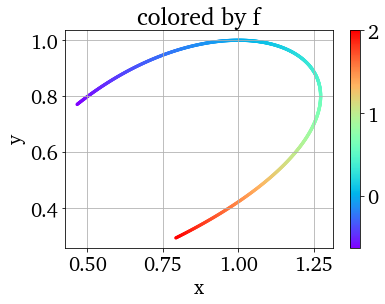

In [2]:
npts = 1001
grid = np.linspace(-0.5,1.,npts)

x = np.exp(grid)*np.cos(grid)**2
y = np.cos(grid)**2

f = grid**3+grid
depvar_name = 'f' # dependent variable name

plt.scatter(x, y, c=f, s=5, cmap='rainbow')
plt.colorbar()
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.title('colored by f')
plt.show()


We now want to assess the manifold in one and two dimensions using `compute_normalized_variance`. In order to use this function, the independent and dependent variables must be arranged into two-dimensional arrays size npts by number of variables. This is done in the following code.

In [3]:
indepvars = np.vstack((x, y)).T
depvars = np.expand_dims(f, axis=1)
print('indepvars shape:', indepvars.shape, '\n  depvars shape:', depvars.shape)


indepvars shape: (1001, 2) 
  depvars shape: (1001, 1)


We can now call `compute_normalized_variance` on both the two-dimensional manifold and one-dimensional slices of it in order to assess the true dimensionality of the manifold (which should be two in this case).
A normalized variance is computed at various bandwidths (Gaussian kernel filter widths) which can provide indications of overlapping states in the manifold (or non-uniqueness) as well as indications of how spread out the dependent variables are. A unique manifold with large spread in the data should better facilitate building models for accurate representations of the dependent variables of interest. Details on the normalized variance equations may be found in the documentation. 

The bandwidths are applied to the independent variables after they are centered and scaled inside a unit box (by default). The bandwidth values may be computed by default according to interpoint distances or may be specified directly by the user.

Below is a demonstration of using default bandwidth values and plotting the resulting normalized variance.


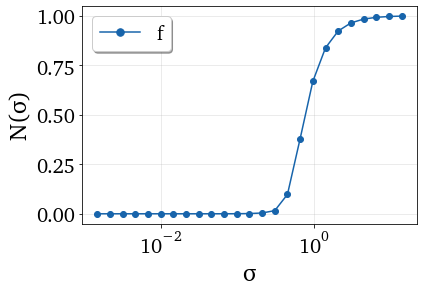

In [4]:
orig2D_default  = compute_normalized_variance(indepvars, depvars, [depvar_name])

plt = plot_normalized_variance(orig2D_default, figure_size=(6,4))
plt.show()


Now we will define an array for the bandwidths in order for the same values to be applied to our manifolds of interest.


In [5]:
bandwidth = np.logspace(-6,1) # array of bandwidth values

# one-dimensional manifold represented by x
orig1Dx = compute_normalized_variance(indepvars[:,:1], depvars, [depvar_name], bandwidth_values=bandwidth)
# one-dimensional manifold represented by y
orig1Dy = compute_normalized_variance(indepvars[:,1:], depvars, [depvar_name], bandwidth_values=bandwidth)
# original two-dimensional manifold
orig2D  = compute_normalized_variance(indepvars,       depvars, [depvar_name], bandwidth_values=bandwidth)


The following plot shows the normalized variance calculated for the dependent variable on each of the three manifolds. A single smooth rise in the normalized variance over bandwidth values indicates a unique manifold. Multiple rises, as can be seen in the one-dimensional manifolds, indicate multiple scales of variation which can be attributed to overlapping states. A curve that rises at larger bandwidth values also indicates more spread in the dependent variable over the manifold. Therefore the desired curve for an optimal manifold is one that has a single smooth rise that occurs at larger bandwidth values.


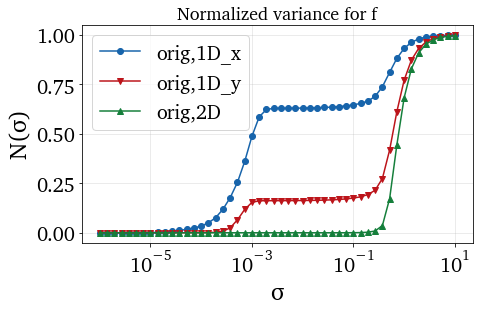

In [6]:
plt = plot_normalized_variance_comparison((orig1Dx, orig1Dy, orig2D), ([], [], []), ('Blues', 'Reds', 'Greens'), title='Normalized variance for '+depvar_name, figure_size=(7,4))
plt.legend(['orig,1D_x', 'orig,1D_y', 'orig,2D'])
plt.show()


The `assess_manifolds` function may be used for a clearer visual comparison of manifolds with multiple dependent variables. The idea behind this comparison is to assess how well a logistic function fits the normalized variance over a log scale of the bandwidth values. The logistic function represents the desired single smooth rise that indicates the uniqueness of the manifold. The shift in this logistic function then gives a representation of the spread in the dependent variable. We use the $R^2$ value for how well a logistic function represents the normalized variance as well as the shift in the logistic fitted function to indicate whether or not a manifold is appropriate for representing the dependent variables of interest. Typically, $R^2$ values less then ~0.999 indicate regions of overlap. The shift may be related to where the normalized variance reaches about 50% of the maximum, but only in the cases of a good logistic fit. Therefore, the shift is used as secondary criteria for a manifold assessment.

In this example, we just have a single dependent variable, but with multiple variables, the `assess_method` input to `assess_manifolds` specifies which logistic parameters across variables should be used to represent a manifold. Options include min, max, or avg.

The output of `assess_manifolds` is a dictionary of the $R^2$ and shift parameters from the logistic fits described above for each manifold as well as a plot for comparing the manifolds, as shown below.
In this plot, the manifold uniqueness parameter is the $R^2$ of the logistic fit and the manifold spread parameter is the shift in the logistic fit.
The `R2` key may be used to access the $R^2$ values for all dependent variables and the `sigma0` key may be used to access the logistic shift value for all dependent variables in the returned dictionary.

We first create a dictionary of the classes returned by `compute_normalized_variance`, then feed this to `assess_manifolds`. The result shows that the two-dimensional representation is the best for our dependent variable as it has both the largest manifold uniqueness parameter and manifold spread parameter. The manifold uniqueness parameter of the one-dimensional manifolds being less than ~0.999 indicates these representations have overlapping states. 

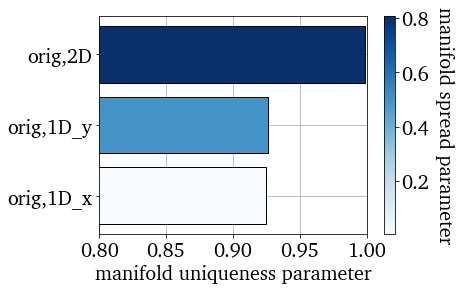

manifold: orig,1D_x   R2: 0.925   sigma0: 5.04e-03
manifold: orig,1D_y   R2: 0.926   sigma0: 4.98e-01
manifold: orig,2D     R2: 0.999   sigma0: 8.07e-01


In [7]:
variance_data_dict = {}
variance_data_dict['orig,1D_x'] = orig1Dx
variance_data_dict['orig,1D_y'] = orig1Dy
variance_data_dict['orig,2D'] = orig2D

assessment = assess_manifolds(variance_data_dict)
for key in assessment.keys():
    print(f"manifold: {key:9}   R2: {assessment[key]['R2'][0]:1.3f}   sigma0: {assessment[key]['sigma0'][0]:1.2e}")


The plots below show more details on the logistic fitting that occurs in `assess_manifolds`. These call the `logistic_fit` function which returns the parameters we analyze for assessing manifolds and show the fit against the original data as well as the difference between the two when `show_plot` is set to True.

The first plot is a one-dimensional manifold with overlap while the second plot is for the two-dimensional manifold.

Example of overlapping manifold resulting in bad logistic fit:


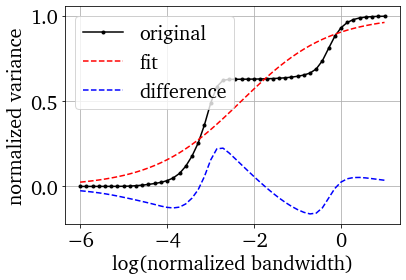

manifold spread parameter (shift in logistic fit): 5.04e-03 
manifold uniqueness parameter (R-squared of logistic fit): 0.925

Example of unique manifold resulting in good logistic fit:


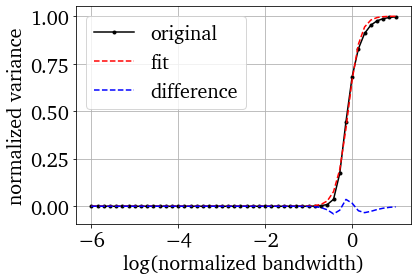

manifold spread parameter (shift in logistic fit): 8.07e-01 
manifold uniqueness parameter (R-squared of logistic fit): 0.999



In [8]:
print('Example of overlapping manifold resulting in bad logistic fit:')
spread, R2 = logistic_fit(orig1Dx.normalized_variance[depvar_name], orig1Dx.bandwidth_values, show_plot=True)
print(f'manifold spread parameter (shift in logistic fit): {spread:1.2e} \nmanifold uniqueness parameter (R-squared of logistic fit): {R2:1.3f}\n')

print('Example of unique manifold resulting in good logistic fit:')
spread, R2 = logistic_fit(orig2D.normalized_variance[depvar_name], orig2D.bandwidth_values, show_plot=True)
print(f'manifold spread parameter (shift in logistic fit): {spread:1.2e} \nmanifold uniqueness parameter (R-squared of logistic fit): {R2:1.3f}\n')


As an example of comparing multiple representations of a manifold in the same dimensional space, we will use PCA. Below, two pca objects are created with different scalings. The first uses the default scaling `std` while the second uses the scaling `pareto`. The plots of the resulting manifolds are shown below for comparison to the original. The dimensions for the PCA manifolds are referred to as PC1 and PC2.

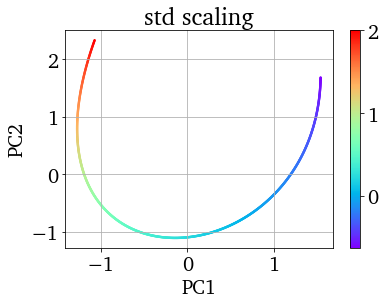

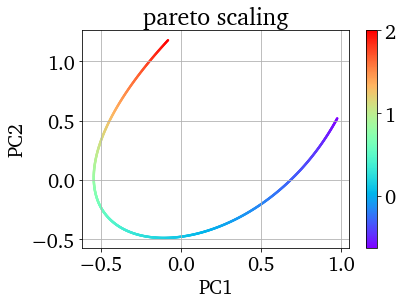

In [9]:
# PCA using std scaling
pca_std = PCA(indepvars)
eta_std = pca_std.transform(indepvars)

plt.scatter(eta_std[:,0], eta_std[:,1], c=f, s=2, cmap='rainbow')
plt.colorbar()
plt.grid()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('std scaling')
plt.show()

# PCA using pareto scaling
pca_pareto = PCA(indepvars,'pareto')
eta_pareto = pca_pareto.transform(indepvars)

plt.scatter(eta_pareto[:,0], eta_pareto[:,1], c=f, s=2, cmap='rainbow')
plt.colorbar()
plt.grid()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('pareto scaling')
plt.show()


We call `compute_normalized_variance` in order to assess these manifolds in one and two dimensional space. Since PCA orders the PCs according the amount of variance explained, we will use PC1 for representing a one-dimensional manifold.

In [10]:
pca1D_std = compute_normalized_variance(eta_std[:,:1], depvars, [depvar_name],bandwidth_values=bandwidth)
pca2D_std = compute_normalized_variance(eta_std,       depvars, [depvar_name],bandwidth_values=bandwidth)

pca1D_pareto = compute_normalized_variance(eta_pareto[:,:1], depvars, [depvar_name],bandwidth_values=bandwidth)
pca2D_pareto = compute_normalized_variance(eta_pareto,       depvars, [depvar_name],bandwidth_values=bandwidth)


Now we add the resulting data to our dictionary containing the original manifold results and feed it to `assess_manifolds` to compare across all manifolds.

These results show that PCA with `std` scaling improved our two-dimensional manifold compared to the original and has a better representation of the dependent variable of interest since it has higher parameters for manifold uniqueness and manifold spread. We can also see that PCA with `pareto` scaling created a similar representation to the original manifold, and therefore offered no additional benefit. The `std` PCA manifold does a much better job at representing the data with one dimension than the other techniques as the manifold uniqueness parameter, while still indicating regions of overlap, indicates a lot fewer regions of overlap than the others. This can be seen in collapsing the `std` PCA figure above onto PC1 alone compared to collapsing the other manifolds onto one dimension.

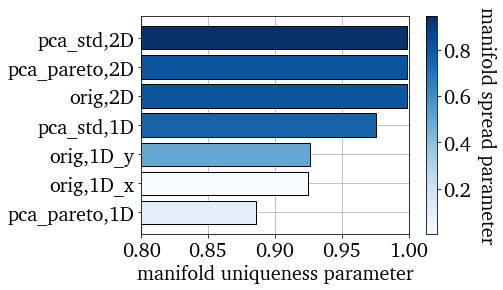

manifold: orig,1D_x       R2: 0.925   sigma0: 5.04e-03
manifold: orig,1D_y       R2: 0.926   sigma0: 4.98e-01
manifold: orig,2D         R2: 0.999   sigma0: 8.07e-01
manifold: pca_std,1D      R2: 0.975   sigma0: 7.55e-01
manifold: pca_std,2D      R2: 0.999   sigma0: 9.44e-01
manifold: pca_pareto,1D   R2: 0.886   sigma0: 9.36e-02
manifold: pca_pareto,2D   R2: 0.999   sigma0: 8.10e-01


In [11]:
variance_data_dict['pca_std,1D'] = pca1D_std
variance_data_dict['pca_std,2D'] = pca2D_std
variance_data_dict['pca_pareto,1D'] = pca1D_pareto
variance_data_dict['pca_pareto,2D'] = pca2D_pareto

assessment = assess_manifolds(variance_data_dict)
for key in assessment.keys():
    print(f"manifold: {key:13}   R2: {assessment[key]['R2'][0]:1.3f}   sigma0: {assessment[key]['sigma0'][0]:1.2e}")


The optimal manifold out of the choices shown above would be the two-dimensional `std` PCA manifold.